In [1]:
!git clone https://github.com/nitish-nayak/dune-cvn.git

Cloning into 'dune-cvn'...
remote: Enumerating objects: 1444, done.
remote: Counting objects: 100% (340/340), done.
remote: Compressing objects: 100% (332/332), done.
remote: Total 1444 (delta 10), reused 337 (delta 7), pack-reused 1104
Receiving objects: 100% (1444/1444), 89.26 MiB | 16.13 MiB/s, done.
Resolving deltas: 100% (60/60), done.
Checking out files: 100% (339/339), done.


In [2]:
%cd dune-cvn

/content/dune-cvn


In [3]:
%ls

dataset/                LICENSE   README.md         test_dune_cvn.ipynb
dataset_highstats/      modules/  requirements.txt  test.py
dune_cvn_nusteam.ipynb  output/   saved_model/      utils.py


In [4]:
from utils import *

In [7]:
# some useful variables for our code
test_values = []
TEST_PARAMS = {'batch_size':1, #batch size for network evaluation (model.predict)
               'images_path':'dataset_highstats', # folder where all the images lie
               'shuffle':False, # whether we want to shuffle the files (doesn't matter for us)
               'test_values':test_values}

In [10]:
# load dataset into IDs, labels
def get_labels(flav):
  print('Reading dataset from serialized file...')
  filename = TEST_PARAMS['images_path']+'/'+flav+'/partition_'+flav+'.p'
  with open(filename, 'rb') as partition_file:
      labels = pk.load(partition_file)
      IDs = list(labels.keys())
  print('Loaded. Number of test examples for flavor %s : %d'%(flav,len(IDs)))
  return IDs, labels

In [11]:
IDs, labels = get_labels('nue')

Reading dataset from serialized file...
Loaded. Number of test examples for flavor nue : 100


In [12]:
print(IDs) # list of strings (strings involve characters inside single quotes or double quotes)

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99']


In [13]:
print(labels) # dictionary which is an "array" of key, value pairs. we need this as a look-up table. 

{'0': [0, 1, 2, 0, 0, 1, 3], '1': [0, 1, 3, 1, 0, 0, 1], '2': [0, 1, 2, 3, 1, 0, 3], '3': [1, 1, 2, 0, 1, 1, 1], '4': [0, 1, 2, 0, 1, 0, 1], '5': [0, 1, 0, 1, 0, 0, 1], '6': [0, 1, 2, 2, 0, 1, 2], '7': [0, 1, 2, 1, 1, 0, 1], '8': [0, 1, 1, 3, 0, 0, 3], '9': [0, 1, 1, 1, 1, 0, 0], '10': [0, 1, 2, 3, 0, 0, 0], '11': [0, 1, 1, 1, 0, 0, 1], '12': [0, 1, 0, 1, 0, 0, 0], '13': [0, 1, 3, 2, 0, 0, 0], '14': [0, 1, 2, 0, 3, 0, 2], '15': [0, 1, 2, 1, 1, 3, 0], '16': [0, 1, 2, 1, 3, 1, 3], '17': [0, 1, 2, 0, 1, 0, 3], '18': [0, 1, 2, 1, 2, 0, 0], '19': [0, 1, 0, 1, 0, 0, 0], '20': [0, 1, 1, 1, 0, 1, 1], '21': [0, 1, 2, 0, 0, 0, 1], '22': [0, 1, 2, 1, 3, 2, 2], '23': [0, 1, 1, 1, 1, 0, 0], '24': [0, 1, 0, 2, 0, 0, 0], '25': [0, 1, 3, 1, 0, 0, 3], '26': [0, 1, 1, 2, 0, 0, 1], '27': [0, 1, 1, 3, 0, 0, 3], '28': [0, 1, 2, 2, 3, 0, 2], '29': [0, 1, 2, 1, 1, 0, 0], '30': [0, 1, 1, 3, 0, 0, 3], '31': [0, 1, 3, 2, 0, 0, 0], '32': [0, 1, 3, 2, 0, 0, 0], '33': [0, 1, 0, 1, 0, 0, 1], '34': [0, 1, 2, 2, 2, 0

In [ ]:
# lookup value for key = '1'
print(labels['1'])

[-1, 3, -1, 1, 1, 0, 0]


In [15]:
import zlib
# function -- give it some inputs ("arguments") and return an output
# this function reads the .gz image file given an argument like '0' or '1' or '2' and so on
def get_pixelmap(key, flav): # with a default value
    path = TEST_PARAMS['images_path']+'/'+flav
    with open(path+'/event'+key+'.gz', 'rb') as image_file:
        pixels = np.fromstring(zlib.decompress(image_file.read()), dtype=np.uint8, sep='').reshape(3, 500, 500)
        return pixels

In [16]:
get_pixelmap('0', 'nue') # calling this function

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  import sys


array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]], dtype=uint8)

In [17]:
import matplotlib.pylab as plt

# useful variable which we use in the code later on
flav_keys=['numucc', 'nuecc', 'nutaucc', 'NC']
# function meant to draw an image. Input here is the image that we obtain from the previous function get_pixelmap
def draw_single_pm(pm):
    fig, axs = plt.subplots(1, 3, figsize=(15, 10))
    fig.suptitle('Pixel Maps')        
    titles = ['U', 'V', 'Z']
    for i in range(3):
        maps = np.swapaxes(pm[i], 0, 1)
        axs[i].imshow(maps, interpolation='none', cmap='cool')
        axs[i].set_xlabel('Wire')
        axs[i].set_ylabel('TDC')
        axs[i].title.set_text(titles[i])
    plt.show()

In [18]:
# convert image from .gz file (3 images, 500x500 pixels) to some format that the neural network understands
def convert_pm(pm):
    views = len(pm)
    planes = pm.shape[1]
    cells = pm.shape[2]
    
    X = [None]*views
    for view in range(views):
        X[view] = np.zeros((1, planes, cells, 1), dtype='float32')
    for view in range(views):
        X[view][0, :, :, :] = pm[view, :, :].reshape(planes, cells, 1)
    return X

In [19]:
# loads the already trained neural network model for evaluation
def get_model(print_model=False): 
    with open('saved_model/model.json', 'r') as json_file:
        loaded_model_json = json_file.read()
        model = model_from_json(loaded_model_json)
        model.load_weights('saved_model/weights.h5')

    if(print_model):
        model.summary()
    return model

In [20]:
model = get_model() # get the neural network model

In [21]:
# print results of network evaluation on input image
def print_pminfo(pm, ID):
    print('Results of network evaluation on pixel map')
    scores = model.predict(convert_pm(pm))
    flav_score = np.max(scores[1], axis=1)
    flav_pred = np.argmax(scores[1], axis=1)
    print('CVN score for pred label : %f, True Label : %s, Pred Label : %s'%
      (flav_score[0], flav_keys[labels[ID][1]], flav_keys[flav_pred[0]]))
    print('CVN score for true label : ', scores[1][0][labels[ID][1]])
    print('All scores :', scores[1])

# draw image and also print results of network evaluation
# flip = True, False (to flip each image horizontally)
# turnoff = 0, 1 or 2 (to turn off particular images before evaluation)
def show_pminfo(key, flav, flip=False, turnoff=None):
    
    pm = get_pixelmap(key, flav)
    print('shape of image : ', pm.shape)
    print('Drawing pixel map')
    pm2 = pm
    if flip:
        #pm2 = np.empty(pm.shape, dtype=np.uint8)
        # flips the image
        for view in range(3):
            pm2[view] = np.flip(pm[view], axis=1)
            
    if turnoff is not None:
        assert (turnoff < 3 and turnoff >= 0), "turnoff can only be 0, 1 or 2"
        pm2[turnoff] = np.zeros(pm[turnoff].shape, dtype=np.uint8)

    draw_single_pm(pm2)
    print_pminfo(pm2, key)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  import sys


shape of image :  (3, 500, 500)
Drawing pixel map


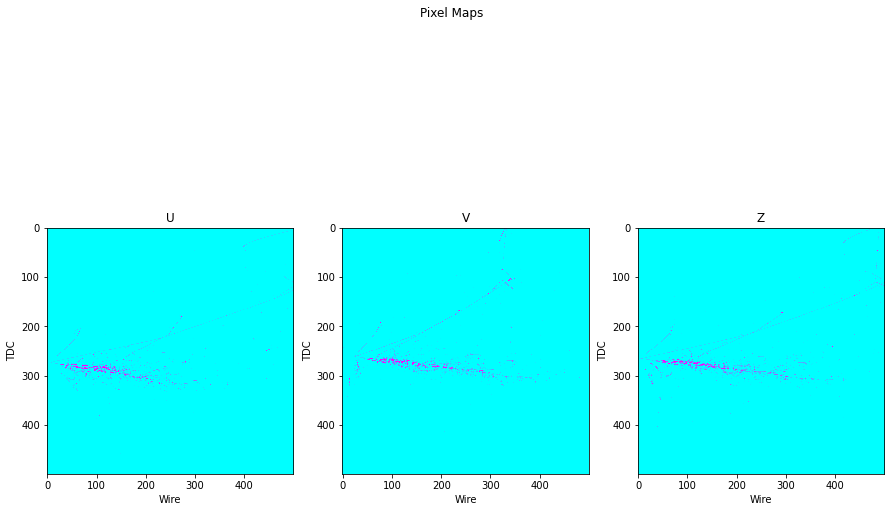

Results of network evaluation on pixel map
CVN score for pred label : 0.805564, True Label : nuecc, Pred Label : nuecc
CVN score for true label :  0.8055639
All scores : [[0.02204059 0.8055639  0.13596834 0.0364271 ]]


In [123]:
show_pminfo('15', 'nue')

In [63]:
def get_pred(key, flav_event):
    pm = get_pixelmap(key, flav_event)
    scores = model.predict(convert_pm(pm))
    flav_pred = np.argmax(scores[1], axis=1)[0]

    return flav_pred

def get_flav_score(key, flav, flav_event):
    tags = np.array(['numu', 'nue', 'nutau', 'nc'])
    pm = get_pixelmap(key, flav_event)
    scores = model.predict(convert_pm(pm))
    flav_score = scores[1][0][np.where(tags == flav)[0][0]]

    return flav_score

In [66]:
confusion_mat = np.zeros((3,3), dtype=np.uint8)
tags = ['numu', 'nue', 'nc']
for f in range(3):
  for i in range(100):
    flav_pred = get_pred(str(i), tags[f])
    if(flav_pred == 2) : continue
    if(flav_pred == 3) : flav_pred = 2
    confusion_mat[f][flav_pred] += 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  import sys


In [67]:
print(confusion_mat)

[[95  1  4]
 [ 0 98  2]
 [ 3  4 90]]


In [73]:
eff_mat = confusion_mat/confusion_mat.sum(axis=1,keepdims=True)
print(eff_mat)

[[0.95       0.01       0.04      ]
 [0.         0.98       0.02      ]
 [0.03092784 0.04123711 0.92783505]]


In [74]:
pur_mat = confusion_mat/confusion_mat.sum(axis=0,keepdims=True)
print(pur_mat)

[[0.96938776 0.00970874 0.04166667]
 [0.         0.95145631 0.02083333]
 [0.03061224 0.03883495 0.9375    ]]


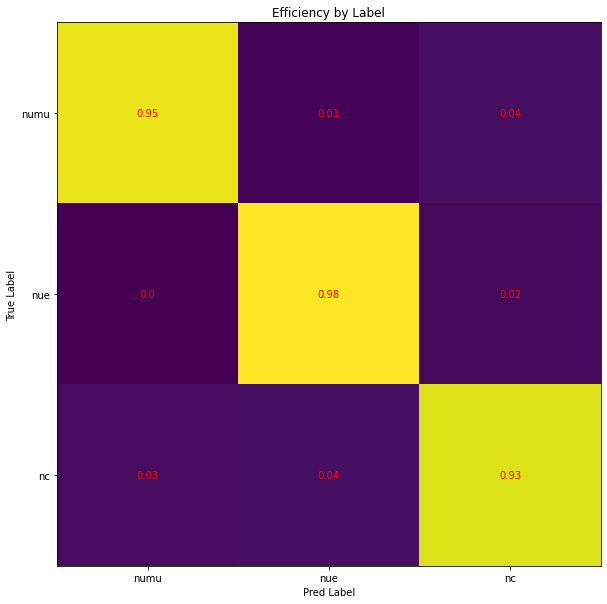

In [95]:
fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(eff_mat, interpolation=None)

ax.set_xticks(np.arange(len(tags)))
ax.set_xticklabels(tags)
ax.set_ylabel('True Label')
ax.set_xlabel('Pred Label')
ax.set_yticks(np.arange(len(tags)))
ax.set_yticklabels(tags)
for i in range(len(tags)):
  for j in range(len(tags)):
    text = ax.text(j, i, round(eff_mat[i, j], 2), ha='center', va='center', color='r')

plt.title('Efficiency by Label')
plt.show()

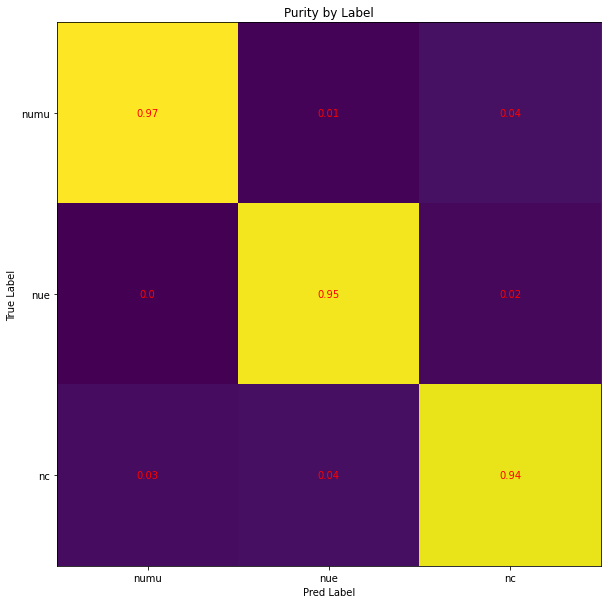

In [94]:
fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(pur_mat, interpolation=None)

ax.set_xticks(np.arange(len(tags)))
ax.set_xticklabels(tags)
ax.set_ylabel('True Label')
ax.set_xlabel('Pred Label')
ax.set_yticks(np.arange(len(tags)))
ax.set_yticklabels(tags)
for i in range(len(tags)):
  for j in range(len(tags)):
    text = ax.text(j, i, round(pur_mat[i, j], 2), ha='center', va='center', color='r')

plt.title('Purity by Label')
plt.show()

In [97]:
sig_scores = []
numu_scores = []
nc_scores = []
tags = ['numu', 'nue', 'nc']
for f in range(3):
  for i in range(100):
    flav_score = get_flav_score(str(i), 'nue', tags[f])
    if(f == 1): sig_scores.append(flav_score)
    if(f == 0): numu_scores.append(flav_score)
    if(f == 2): nc_scores.append(flav_score)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  import sys


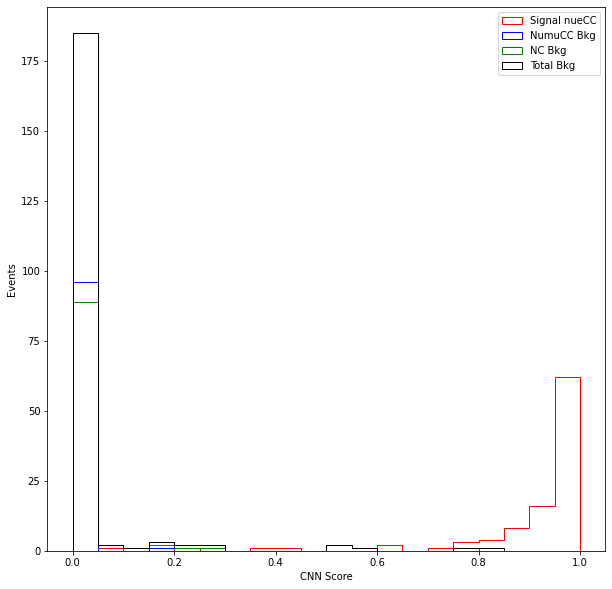

In [111]:
b = np.arange(0, 1.05, 0.05)
fig, ax = plt.subplots(figsize=(10, 10))
ax.hist(np.array(sig_scores), bins=b, histtype='step',color='red',linestyle='solid',label='Signal nueCC')
ax.hist(np.array(numu_scores), bins=b, histtype='step',color='blue',linestyle='solid',label='NumuCC Bkg')
ax.hist(np.array(nc_scores), bins=b, histtype='step',color='green',linestyle='solid',label='NC Bkg')
ax.hist(np.array(nc_scores+numu_scores), bins=b, histtype='step',color='black',linestyle='solid',label='Total Bkg')
ax.legend(loc='best')
ax.set_ylabel('Events')
ax.set_xlabel('CNN Score')
plt.show()

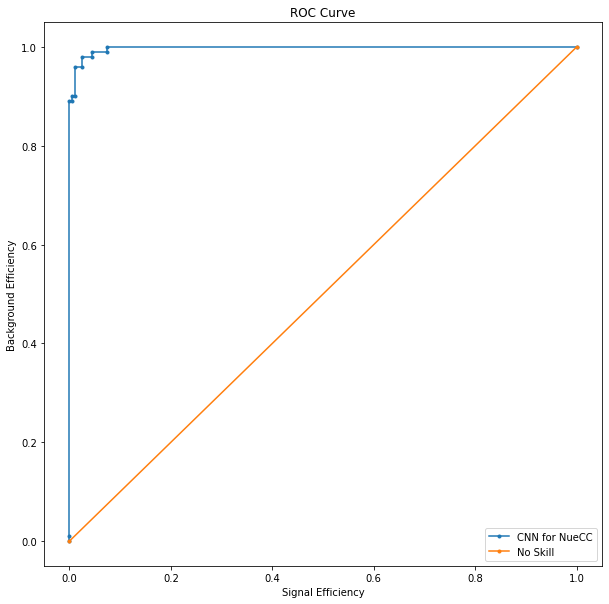

AUC scores for (CNN, No Skill) : 0.998, 0.500


In [122]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

lr_fpr, lr_tpr, _ = roc_curve(200*[0] + 100*[1], numu_scores+nc_scores+sig_scores)
ns_fpr, ns_tpr, _ = roc_curve(200*[0] + 100*[1], 300*[1])
fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(lr_fpr, lr_tpr, marker='.', label='CNN for NueCC')
ax.plot(ns_fpr, ns_tpr, marker='.', label='No Skill')
ax.legend(loc='best')
ax.set_title('ROC Curve')
ax.set_xlabel('Signal Efficiency')
ax.set_ylabel('Background Efficiency')
plt.show()
lr_auc = roc_auc_score(200*[0] + 100*[1], numu_scores+nc_scores+sig_scores)
ns_auc = roc_auc_score(200*[0] + 100*[1], 300*[1])
print('AUC scores for (CNN, No Skill) : %0.03f, %0.03f'%(lr_auc, ns_auc))